# **Heart Rate Prediction Using Time Series**

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objects as go


# Statistics
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults, SARIMAXSpecification
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error, mean_squared_error
from dateutil.parser import parse
from statsmodels.tools.eval_measures import rmse

%matplotlib inline
plt.rcParams.update({'figure.figsize': (12, 8), 'figure.dpi': 100})
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Reading in the data
df = pd.read_csv('PT_Train.csv', index_col=0, parse_dates=True)

#Casting the heart rate column to float
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].astype(float)

# First 5 rows of the dataset
df.head()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 15:09:00,139.0,41,NaN,NaN
2015-08-17 15:10:00,144.0,40,92.0,140.0
2015-08-17 15:11:00,140.0,42,89.0,144.0
2015-08-17 15:12:00,138.0,45,93.0,141.0
2015-08-17 15:13:00,133.0,42,94.0,134.0


In [ ]:
df.tail()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp (GMT),,,,
2015-08-17 18:50:00,159.0,51,NaN,NaN
2015-08-17 18:51:00,151.0,64,NaN,NaN
2015-08-17 18:52:00,140.0,64,NaN,NaN
2015-08-17 18:53:00,140.0,55,NaN,NaN
2015-08-17 18:54:00,138.0,54,NaN,NaN


In [ ]:
# Summary of the dataset
df.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,226.000000,226.000000,191.000000,191.000000
mean,2315.615044,2219.216814,83.450262,126.335079
std,11351.588825,11370.093548,29.802974,46.348142
min,106.000000,34.000000,-1.000000,-1.000000
25%,136.000000,38.000000,92.000000,134.000000
50%,145.000000,46.000000,93.000000,139.000000
75%,156.000000,53.000000,95.000000,149.000000
max,61442.000000,61442.000000,98.000000,166.000000


In [ ]:
#checking for null values
df.isna().sum()

Lifetouch Heart Rate           0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64

In [ ]:

# Select how you wish to treat missing values according to the input
df = df.ffill()
df = df.bfill()


In [ ]:
# Missing values for every column
df.isna().sum()

Lifetouch Heart Rate          0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

In [ ]:
#Replacing the missing values with np.nan
df = df.replace({'Lifetouch Heart Rate':{61441:np.nan, 61442:np.nan}, 'Lifetouch Respiration Rate':{61441:np.nan, 61442:np.nan}})

In [ ]:
#Replacing the missing values with the previous value
df = df.ffill()

In [ ]:
# Missing values for every column
df.isna().sum()

Lifetouch Heart Rate          0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
dtype: int64

## Visualizations with Plotly

In [ ]:
#Lifetouch Heart Rate

fig = px.line(df['Lifetouch Heart Rate'], width=900, height=600)

# Set the background color to yellow
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

# Set the line color to blue
fig.update_traces(line_color='red')

# Show grid lines
fig.update_layout(
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "Lifetouch Heart Rate",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

In [ ]:
#Lifetouch Respiration Rate

fig = px.line(df['Lifetouch Respiration Rate'], width=900, height=600)

# Set the background color to yellow
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

# Set the line color to blue
fig.update_traces(line_color='red')

# Show grid lines
fig.update_layout(
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "Lifetouch Respiration Rate",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

In [ ]:
#Oximeter SpO2

fig = px.line(df['Oximeter SpO2'], width=900, height=600)

# Set the background color to yellow
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

# Set the line color to blue
fig.update_traces(line_color='red')

# Show grid lines
fig.update_layout(
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "Oximeter Sp02",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

In [ ]:
#Oximeter Pulse

fig = px.line(df['Oximeter Pulse'], width=900, height=600)

# Set the background color to yellow
fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)

# Set the line color to blue
fig.update_traces(line_color='red')

# Show grid lines
fig.update_layout(
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "Oximeter Pulse",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

In [ ]:
#Heart and respiration rate

fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Lifetouch Heart Rate'],
    marker=dict(
        color="red"
    ),
    showlegend=True, name='Heart Rate'
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Lifetouch Respiration Rate'],
    marker=dict(
        color="green"
    ),
    showlegend=True, name= 'Respiration Rate'
))


# Show grid lines
fig.update_layout(plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "Heart and Respiration Rate",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

In [ ]:
#Oximeter SpO2 and Pulse

fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Oximeter SpO2'],
    marker=dict(
        color="red"
    ),
    showlegend=True, name='Oximeter SpO2'
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Oximeter Pulse'],
    marker=dict(
        color="green"
    ),
    showlegend=True, name= 'Oximeter Pulse'
))


# Show grid lines
fig.update_layout(plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "Oximeter Pulse and SpO2",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

## ETS DECOMPOSITION

In [ ]:
results = seasonal_decompose(df['Lifetouch Heart Rate'], period = 60)

import plotly.subplots as sp
import plotly.graph_objs as go

# Create a grid of subplots
fig2 = sp.make_subplots(rows=4, cols=1)

# Add a trace to the first subplot
fig2.add_trace(go.Scatter(x=df.index, y=df['Lifetouch Heart Rate'], name='Heart Rate'), row=1, col=1)

# Add a trace to the second subplot
fig2.add_trace(go.Scatter(x=df.index, y=results.trend, name='Trend'), row=2, col=1)

# Add a trace to the third subplot
fig2.add_trace(go.Scatter(x=df.index, y=results.seasonal, name='Seasonal'), row=3, col=1)

# Add a trace to the fourth subplot
fig2.add_trace(go.Scatter(x=df.index, y=results.resid, name='Residual'), row=4, col=1)

# Update the layout of the subplots
fig2.update_layout(title_text='ETS Decomposition', plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'), )

# Add y-axis labels to each subplot
fig2.update_yaxes(title_text="Heart Rate", row=1, col=1)
fig2.update_yaxes(title_text="Trend", row=2, col=1)
fig2.update_yaxes(title_text="Seasonal", row=3, col=1)
fig2.update_yaxes(title_text="Residual", row=4, col=1)
# Show the plot
fig2.show()

## Testing for Stationarity
### Augmented Dickey-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
print('Stationarity test for the Heart Rate Column')
adf_test(df['Lifetouch Heart Rate'])
print()

print('Stationarity test for the Respiration Rate Column')
adf_test(df['Lifetouch Respiration Rate'])
print()

print('Stationarity test for the Oximeter SpO2 Column')
adf_test(df['Oximeter SpO2'])
print()

print('Stationarity test for the Oximeter Pulse Column')
adf_test(df['Oximeter Pulse'])

Stationarity test for the Heart Rate Column
Augmented Dickey-Fuller Test: 
ADF test statistic       -2.006298
p-value                   0.283818
# lags used               4.000000
# observations          221.000000
critical value (1%)      -3.460291
critical value (5%)      -2.874709
critical value (10%)     -2.573789
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Stationarity test for the Respiration Rate Column
Augmented Dickey-Fuller Test: 
ADF test statistic       -0.955644
p-value                   0.769097
# lags used               5.000000
# observations          220.000000
critical value (1%)      -3.460428
critical value (5%)      -2.874769
critical value (10%)     -2.573821
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Stationarity test for the Oximeter SpO2 Column
Augmented Dickey-Fuller Test: 
ADF test statistic       -2.891988

## Testing for Causality
### Granger Causality Test

In [ ]:
grangercausalitytests(df[['Lifetouch Heart Rate','Lifetouch Respiration Rate']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.4368 , p=0.0009  , df_denom=222, df_num=1
ssr based chi2 test:   chi2=11.5913 , p=0.0007  , df=1
likelihood ratio test: chi2=11.3026 , p=0.0008  , df=1
parameter F test:         F=11.4368 , p=0.0009  , df_denom=222, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9751  , p=0.0030  , df_denom=219, df_num=2
ssr based chi2 test:   chi2=12.2231 , p=0.0022  , df=2
likelihood ratio test: chi2=11.9013 , p=0.0026  , df=2
parameter F test:         F=5.9751  , p=0.0030  , df_denom=219, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9717  , p=0.1192  , df_denom=216, df_num=3
ssr based chi2 test:   chi2=6.1067  , p=0.1065  , df=3
likelihood ratio test: chi2=6.0246  , p=0.1104  , df=3
parameter F test:         F=1.9717  , p=0.1192  , df_denom=216, df_num=3


### Model Building
### Auto-Arima

In [ ]:
auto_arima(df['Lifetouch Heart Rate'], start_p=1, start_q=1, max_p=2, max_q=2, seasonal=True, m=60, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[60] intercept   : AIC=1359.960, Time=5.65 sec
 ARIMA(0,1,0)(0,0,0)[60] intercept   : AIC=1376.400, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[60] intercept   : AIC=1373.484, Time=2.68 sec
 ARIMA(0,1,1)(0,0,1)[60] intercept   : AIC=1369.808, Time=2.66 sec
 ARIMA(0,1,0)(0,0,0)[60]             : AIC=1374.400, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[60] intercept   : AIC=1357.960, Time=4.55 sec
 ARIMA(1,1,1)(0,0,0)[60] intercept   : AIC=1360.461, Time=0.03 sec
 ARIMA(1,1,1)(0,0,2)[60] intercept   : AIC=1359.960, Time=87.55 sec
 ARIMA(1,1,1)(1,0,0)[60] intercept   : AIC=1358.010, Time=3.67 sec
 ARIMA(1,1,1)(1,0,2)[60] intercept   : AIC=inf, Time=185.32 sec
 ARIMA(1,1,0)(0,0,1)[60] intercept   : AIC=1373.261, Time=1.64 sec
 ARIMA(2,1,1)(0,0,1)[60] intercept   : AIC=1358.076, Time=3.12 sec
 ARIMA(1,1,2)(0,0,1)[60] intercept   : AIC=1351.877, Time=3.89 sec
 ARIMA(1,1,2)(0,0,0)[60] intercept   : AIC=1354.721, Time=0.03 sec
 ARIMA(1,1,2)(1,0,1)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  226
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 60)   Log Likelihood                -668.294
Date:                             Sun, 19 Feb 2023   AIC                           1348.588
Time:                                     17:49:22   BIC                           1369.085
Sample:                                 08-17-2015   HQIC                          1356.861
                                      - 08-17-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1928      0.151     -1.275      0.202      -0.489       0.104
ar.L2          0.3099      0.104      2.983      0.003       0.106       0.513
ma.L1          0.0481      0.128      0.377      0.706      -0.202       0.298
ma.L2         -0.6867      0.111     -6.184      0.000      -0.904      -0.469
ar.S.L60      -0.2071      0.076     -2.744      0.006      -0.355      -0.059
sigma2        21.9462      1.297     16.926      0.000      19.405      24.487
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              1852.63
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Data Splitting

In [ ]:
print(df['Lifetouch Heart Rate'].shape)
train=df['Lifetouch Heart Rate'].iloc[:-20]
test=df['Lifetouch Heart Rate'].iloc[-20:]
print(train.shape,test.shape)

(226,)
(206,) (20,)


### SARIMA Model training

In [ ]:
mod = SARIMAX(train,
                    order=(2, 1, 2),
                    seasonal_order=(1, 0, 0, 60),
                    enforce_stationarity=True,
                    enforce_invertibility=False, mle_regression=True)

results = mod.fit()

#print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97389D+00    |proj g|=  4.02911D-02

At iterate    5    f=  2.97120D+00    |proj g|=  1.64402D-02

At iterate   10    f=  2.97076D+00    |proj g|=  8.39313D-04

At iterate   15    f=  2.97075D+00    |proj g|=  1.88976D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   4.332D-06   2.971D+00
  F =   2.9707505555749361     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


### Testing the model

In [ ]:
start=len(train)
end=len(train)+len(test)-1
test_forecast=results.predict(start=start,end=end, typ='levels')
#print(pred)
#test_forecast.index=train.index[start:end+1]


print(test_forecast)

2015-08-17 18:35:00    155.816460
2015-08-17 18:36:00    155.511127
2015-08-17 18:37:00    154.828208
2015-08-17 18:38:00    155.001133
2015-08-17 18:39:00    153.816095
2015-08-17 18:40:00    154.156036
2015-08-17 18:41:00    154.560916
2015-08-17 18:42:00    153.684077
2015-08-17 18:43:00    154.865213
2015-08-17 18:44:00    155.922294
2015-08-17 18:45:00    155.915910
2015-08-17 18:46:00    156.219187
2015-08-17 18:47:00    156.066942
2015-08-17 18:48:00    155.469862
2015-08-17 18:49:00    154.870118
2015-08-17 18:50:00    155.619157
2015-08-17 18:51:00    155.169706
2015-08-17 18:52:00    154.271928
2015-08-17 18:53:00    155.020129
2015-08-17 18:54:00    154.271865
Freq: T, Name: predicted_mean, dtype: float64


### Plotting predicted and actual test values

In [ ]:
fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=test_forecast.index,
    y=test_forecast,
    marker=dict(
        color="red"
    ),
    showlegend=True, name='Predicted Test Values'
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=test.index,
    y=test,
    marker=dict(
        color="Orange"
    ),
    showlegend=True, name= 'Actual Test Values'
))


# Show grid lines
fig.update_layout(plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "SARIMAX Model",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

### Evaluating the model

In [ ]:
print(test.mean())
print(test_forecast.mean())
print(rmse(test, test_forecast))
print(test.mean() - test_forecast.mean())

152.1
155.05281818702508
6.644806887320173
-2.9528181870250876


### Final model training

In [ ]:
fore_model = SARIMAX(df['Lifetouch Heart Rate'],
                    order=(2, 1, 2),
                    seasonal_order=(1, 0, 0, 60),
                    enforce_stationarity=True,
                    enforce_invertibility=False, mle_regression=True)

Sarima_results = fore_model.fit()

#print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96408D+00    |proj g|=  8.65897D-02

At iterate    5    f=  2.95751D+00    |proj g|=  1.37476D-02

At iterate   10    f=  2.95706D+00    |proj g|=  1.65689D-03

At iterate   15    f=  2.95705D+00    |proj g|=  1.36133D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     19      1     0     0   1.361D-05   2.957D+00
  F =   2.9570531117982535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [ ]:
final_predictions = Sarima_results.forecast(20)
fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=df['Lifetouch Heart Rate'].index,
    y=df['Lifetouch Heart Rate'],
    marker=dict(
        color="red"
    ),
    showlegend=True, name='Real Data'
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=final_predictions.index,
    y=final_predictions,
    marker=dict(
        color="Orange"
    ),
    showlegend=True, name= 'Next 20 Forecasts'
))


# Show grid lines
fig.update_layout(plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "The next 20 predictions",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

In [ ]:
final = final_predictions.values

In [ ]:
final

array([140.68226763, 142.52977522, 142.36788764, 142.9802652 ,
       142.79749708, 142.56834473, 143.99006175, 144.46708904,
       145.8961165 , 145.919588  , 144.87300464, 144.88239482,
       144.25581905, 145.0882188 , 145.5000913 , 145.29464019,
       146.32918989, 145.50142623, 146.74368714, 145.08703078])

In [ ]:
import json

predictions = [140.68226763, 142.52977522, 142.36788764, 142.9802652 ,
       142.79749708, 142.56834473, 143.99006175, 144.46708904,
       145.8961165 , 145.919588  , 144.87300464, 144.88239482,
       144.25581905, 145.0882188 , 145.5000913 , 145.29464019,
       146.32918989, 145.50142623, 146.74368714, 145.08703078]

data = []
for pred in predictions:
    data.append({'prediction': pred})

print(data[0:5])

submission_file_path = "submission.json"
with open(submission_file_path, 'w') as fp:
    fp.write('\n'.join(json.dumps(i) for i in data))

[{'prediction': 140.68226763}, {'prediction': 142.52977522}, {'prediction': 142.36788764}, {'prediction': 142.9802652}, {'prediction': 142.79749708}]


## Holt-Winters Model

In [ ]:
model_holt = SimpleExpSmoothing(train).fit(smoothing_level=0.6,optimized=False)

print(model_holt.summary())

holt_test_forecast = model_holt.forecast(20)

                        SimpleExpSmoothing Model Results                        
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  206
Model:               SimpleExpSmoothing   SSE                           5347.663
Optimized:                        False   AIC                            674.847
Trend:                             None   BIC                            681.503
Seasonal:                          None   AICC                           675.046
Seasonal Periods:                  None   Date:                 Sun, 19 Feb 2023
Box-Cox:                          False   Time:                         09:16:22
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6000000                alpha                False
initial_level              139.000

### Evaluating the model

In [ ]:
print(rmse(test, holt_test_forecast))
print(test.mean())
print(holt_test_forecast.mean())
print(test.mean() - holt_test_forecast.mean())

7.504877455841614
152.1
156.0665079890503
-3.9665079890503137


In [ ]:
adf_test(df['Lifetouch Heart Rate'].diff())

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.370467e+00
p-value                 2.670860e-13
# lags used             5.000000e+00
# observations          2.190000e+02
critical value (1%)    -3.460567e+00
critical value (5%)    -2.874830e+00
critical value (10%)   -2.573853e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=holt_test_forecast.index,
    y=holt_test_forecast,
    marker=dict(
        color="red"
    ),
    showlegend=True, name='Predicted Test Values'
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=test.index,
    y=test,
    marker=dict(
        color="Orange"
    ),
    showlegend=True, name= 'Actual Test Values'
))


# Show grid lines
fig.update_layout(plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "Holt-Winters Model",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

### Final Model training

In [ ]:
model_holt2 = SimpleExpSmoothing(df['Lifetouch Heart Rate']).fit(smoothing_level=0.6,optimized=False)

print(model_holt2.summary())

final_holt_predictions = model_holt2.forecast(20)


                        SimpleExpSmoothing Model Results                        
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  226
Model:               SimpleExpSmoothing   SSE                           5812.319
Optimized:                        False   AIC                            737.867
Trend:                             None   BIC                            744.708
Seasonal:                          None   AICC                           738.048
Seasonal Periods:                  None   Date:                 Sun, 19 Feb 2023
Box-Cox:                          False   Time:                         09:16:22
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.6000000                alpha                False
initial_level              139.000

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Lifetouch Heart Rate'].index,
    y=df['Lifetouch Heart Rate'],
    marker=dict(
        color="red"
    ),
    showlegend=True, name='Real Data'
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=final_holt_predictions.index,
    y=final_holt_predictions,
    marker=dict(
        color="Orange"
    ),
    showlegend=True, name= 'Next 20 Forecasts'
))


# Show grid lines
fig.update_layout(plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "The next 20 predictions",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

## Simple Exponential Smoothing

### Model Training

In [ ]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error


# Fit the model
model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()

# Evaluate the model
SES_test_forecast = model.forecast(20)




In [ ]:
fig = go.Figure()

# add line / trace 1 to figure
fig.add_trace(go.Scatter(
    x=SES_test_forecast.index,
    y=SES_test_forecast,
    marker=dict(
        color="red"
    ),
    showlegend=True, name='Predicted Test Values'
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=test.index,
    y=test,
    marker=dict(
        color="Orange"
    ),
    showlegend=True, name= 'Actual Test Values'
))


# Show grid lines
fig.update_layout(plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "Simple Exponential Smoothing Model",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

### Final model training

In [ ]:
model2 = ExponentialSmoothing(df['Lifetouch Heart Rate'], seasonal_periods=12, trend='add', seasonal='add').fit()

# Evaluate the model
final_SES_predictions = model2.forecast(20)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Lifetouch Heart Rate'].index,
    y=df['Lifetouch Heart Rate'],
    marker=dict(
        color="red"
    ),
    showlegend=True, name='Real Data'
))

# add line / trace 2 to figure
fig.add_trace(go.Scatter(
    x=final_SES_predictions.index,
    y=final_SES_predictions,
    marker=dict(
        color="Orange"
    ),
    showlegend=True, name= 'Next 20 Forecasts'
))


# Show grid lines
fig.update_layout(plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white'),
    xaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    yaxis=dict(showgrid=True, gridcolor='gray', gridwidth=1),
    title={
        'text': "The next 20 predictions",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

## Model Evaluation

In [ ]:
print(rmse(test, SES_test_forecast))
print(test.mean())
print(SES_test_forecast.mean())
print(test.mean() - SES_test_forecast.mean())

8.322931587398356
152.1
156.76503584330825
-4.66503584330826


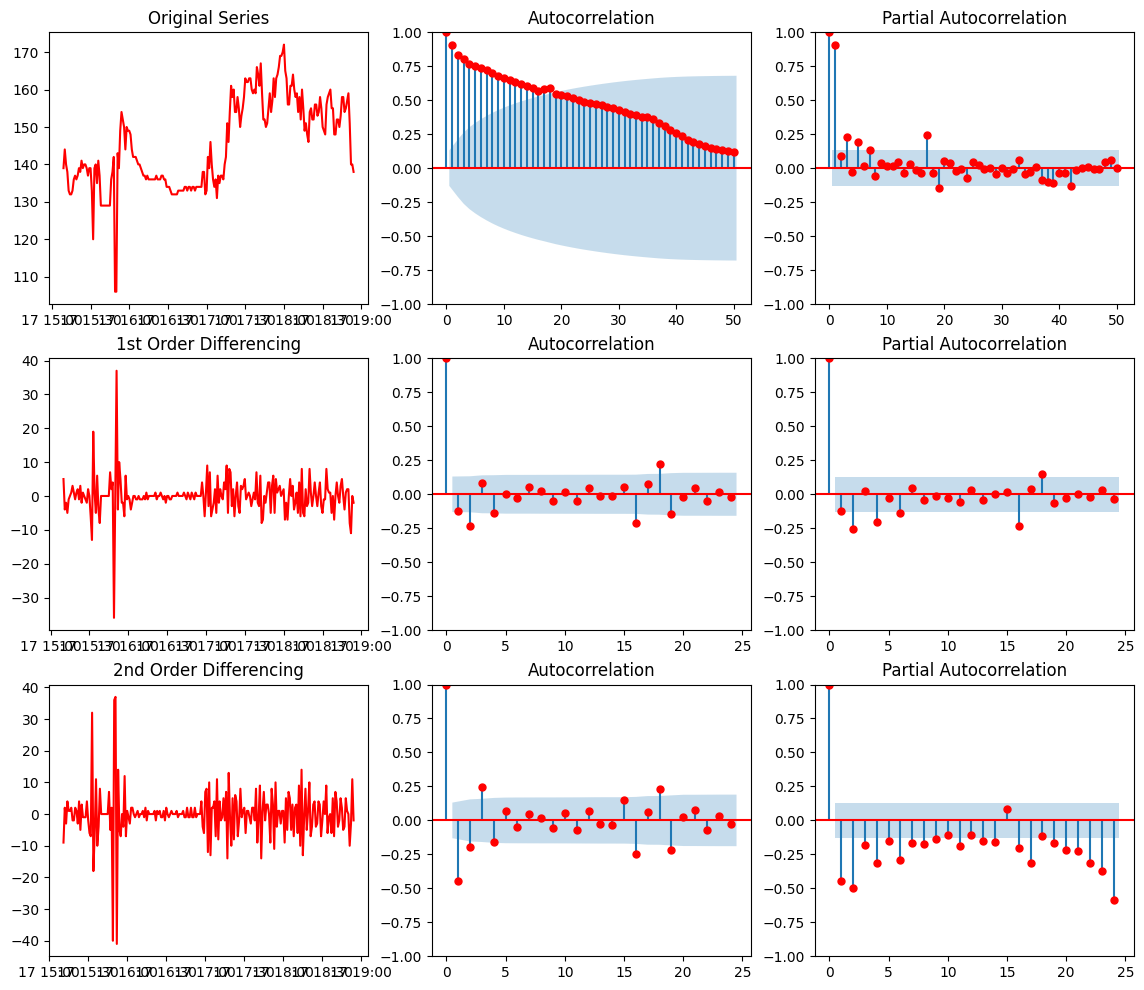

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(14,12), dpi=100)
axes[0, 0].plot(df['Lifetouch Heart Rate'], color='r')
axes[0, 0].set_title('Original Series')
plot_acf(df['Lifetouch Heart Rate'], lags=50, ax=axes[0, 1], color='r')
plot_pacf(df['Lifetouch Heart Rate'], lags=50, ax=axes[0, 2], color='r')

# 1st Differencing
axes[1, 0].plot(df['Lifetouch Heart Rate'].diff(), color='r')
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Lifetouch Heart Rate'].diff().dropna(), ax=axes[1, 1], color='r')
plot_pacf(df['Lifetouch Heart Rate'].diff().dropna(), ax=axes[1, 2], color='r')

# 2nd Differencing
axes[2, 0].plot(df['Lifetouch Heart Rate'].diff().diff(), color='r')
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Lifetouch Heart Rate'].diff().diff().dropna(), ax=axes[2, 1], color='r')
plot_pacf(df['Lifetouch Heart Rate'].diff().diff().dropna(), ax=axes[2, 2], color='r')

plt.show();

## Alhamdulillah